In [ ]:
!pip install scikit-learn torch torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# Dataset Loading and EDA

In [ ]:
df = pd.read_csv('data/coorteeqsrafva.csv', sep=';', header=0, index_col=0)

print(df.shape)
df.head()

(6428, 30)


,diagnosi,ecg_id,ritmi,patient_id,age,sex,height,weight,nurse,site,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,STACH,10900,VA,15654.0,54.0,0,NaN,NaN,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/10000/10900_lr,records500/10000/10900_hr
1,AFLT,10900,AF,15654.0,54.0,0,NaN,NaN,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/10000/10900_lr,records500/10000/10900_hr
2,SR,8209,SR,12281.0,55.0,0,NaN,NaN,1.0,2.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/08000/08209_lr,records500/08000/08209_hr
3,STACH,17620,VA,2007.0,29.0,1,164.0,56.0,7.0,1.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/17000/17620_lr,records500/17000/17620_hr
4,SBRAD,12967,VA,8685.0,57.0,0,NaN,NaN,0.0,0.0,...,False,NaN,", I-AVR,",NaN,NaN,NaN,NaN,1,records100/12000/12967_lr,records500/12000/12967_hr


## Analysis of label distribution

In [ ]:
print('Normal (SR) has a total of {} rows'.format(df.loc[df['ritmi'] == 'SR'].shape[0]))
print('Atrial Fibrillation (AF) has a total of {} rows'.format(df.loc[df['ritmi'] == 'AF'].shape[0]))
print('Other arrhythmia (VA) has a total of {} rows'.format(df.loc[df['ritmi'] == 'VA'].shape[0]))

Normal (SR) has a total of 2000 rows
Atrial Fibrillation (AF) has a total of 1587 rows
Other arrhythmia (VA) has a total of 2841 rows


## Loading of ECG waveform data

In [ ]:
ecgeq_arr = np.load('data/ecgeq-500hzsrfava.npy')
print(ecgeq_arr.shape)
ecgeq_arr

(6428, 5000, 12)


array([[[-0.005,  0.135,  0.14 , ..., -0.21 , -0.145, -0.08 ],
        [-0.005,  0.135,  0.14 , ..., -0.21 , -0.145, -0.08 ],
        [-0.005,  0.135,  0.14 , ..., -0.21 , -0.145, -0.08 ],
        ...,
        [ 0.03 , -0.045, -0.075, ..., -0.02 , -0.035, -0.045],
        [ 0.03 , -0.045, -0.075, ..., -0.02 , -0.035, -0.045],
        [ 0.03 , -0.045, -0.075, ..., -0.02 , -0.035, -0.045]],

       [[-0.005,  0.135,  0.14 , ..., -0.21 , -0.145, -0.08 ],
        [-0.005,  0.135,  0.14 , ..., -0.21 , -0.145, -0.08 ],
        [-0.005,  0.135,  0.14 , ..., -0.21 , -0.145, -0.08 ],
        ...,
        [ 0.03 , -0.045, -0.075, ..., -0.02 , -0.035, -0.045],
        [ 0.03 , -0.045, -0.075, ..., -0.02 , -0.035, -0.045],
        [ 0.03 , -0.045, -0.075, ..., -0.02 , -0.035, -0.045]],

       [[-0.17 , -0.13 ,  0.04 , ..., -0.14 , -0.05 , -0.03 ],
        [-0.17 , -0.13 ,  0.04 , ..., -0.14 , -0.05 , -0.03 ],
        [-0.17 , -0.13 ,  0.04 , ..., -0.14 , -0.05 , -0.03 ],
        ...,
        [ 0.

## Pre-processing of the dataset

In [ ]:
afib_df = df.copy()

# drop columns
afib_df = afib_df.drop(columns=['ecg_id', 'patient_id', 'nurse', 'site', 'device', 'report', 'scp_codes', 'infarction_stadium1', 'infarction_stadium2', 'validated_by', 'second_opinion', 'initial_autogenerated_report', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'filename_lr', 'filename_hr'])

# dictionary to hold values for ritmi column
num_di = {'SR': 0, 'AF': 1, 'VA': 2}

# replace SR with 0, AF with 1, VA with 2
afib_df = afib_df.replace({'ritmi': num_di})

# dictionary to hold values for validated_by_human column
bool_di = {False: 0, True: 1}

# replace False with 0, True with 1
afib_df = afib_df.replace({'validated_by_human': bool_di})

## EDA on the ECG waveform data per label

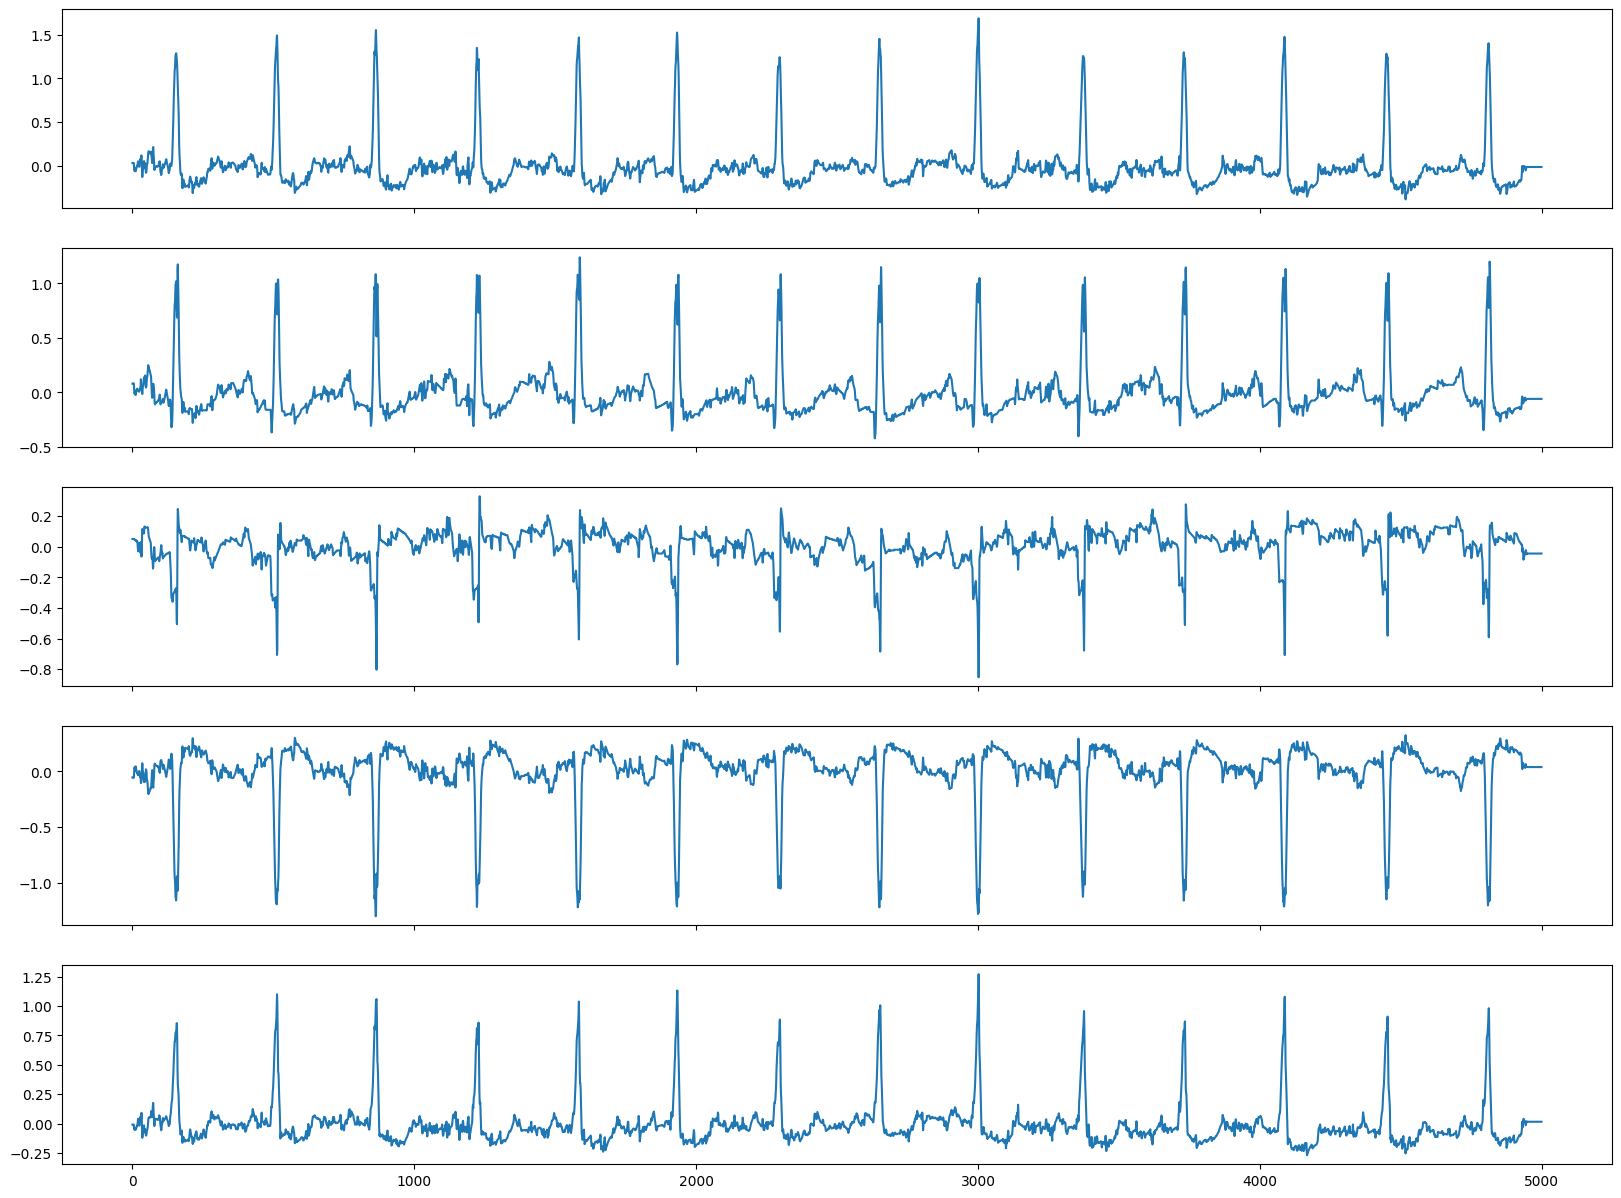

In [ ]:
# Regular heart rate
normal_case = random.choice(list(afib_df[afib_df['ritmi']==0].index))

# plot using numpy array data with afib_case as layers.
fig,ax = plt.subplots(5,1,figsize=(20,15),sharex=True,sharey=False)

for i in range(5):
    ax[i].plot(ecgeq_arr[normal_case,:,i])

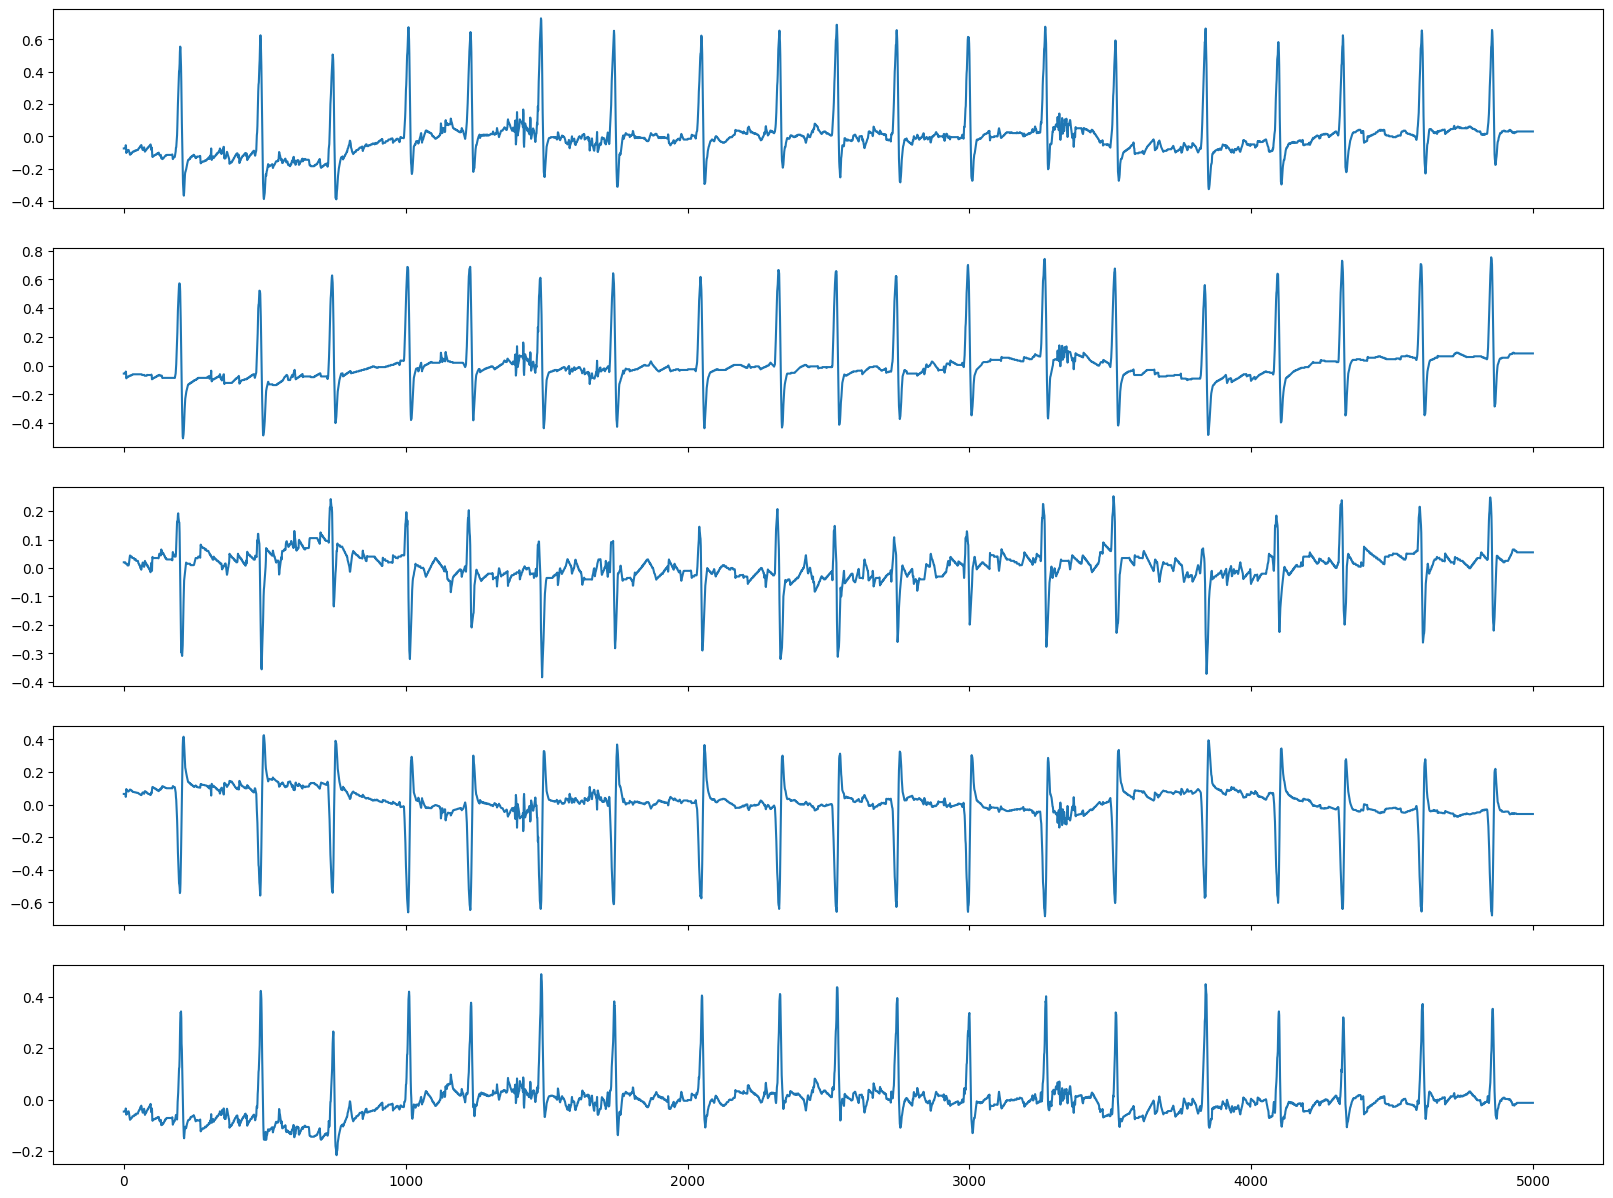

In [ ]:
# AFib Data
afib_case = random.choice(list(afib_df[afib_df['ritmi']==1].index))

# plot using numpy array data with afib_case as layers.
fig,ax = plt.subplots(5,1,figsize=(20,15),sharex=True,sharey=False)
for i in range(5):
    ax[i].plot(ecgeq_arr[afib_case,:,i])

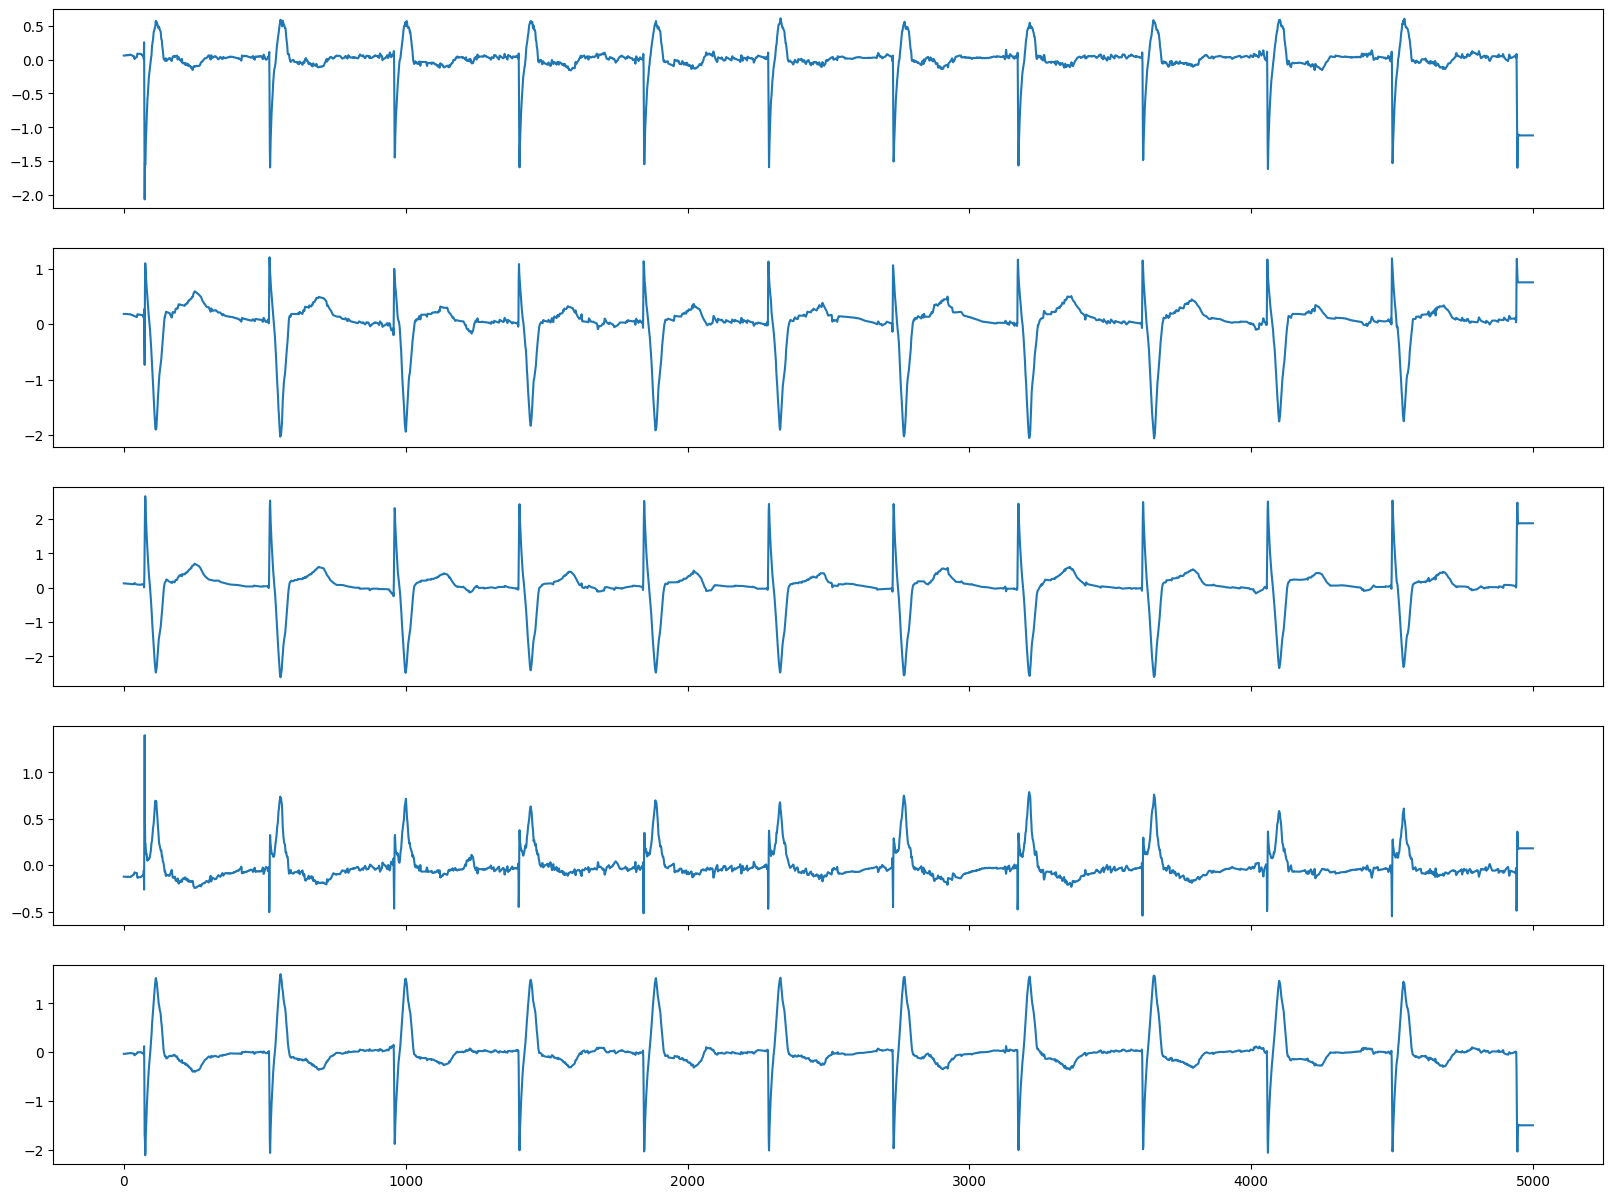

In [ ]:
# Arrythmia
other_case = random.choice(list(afib_df[afib_df['ritmi']==2].index))

# plot using numpy array data with afib_case as layers.
fig,ax = plt.subplots(5,1,figsize=(20,15),sharex=True,sharey=False)
for i in range(5):
    ax[i].plot(ecgeq_arr[other_case,:,i])

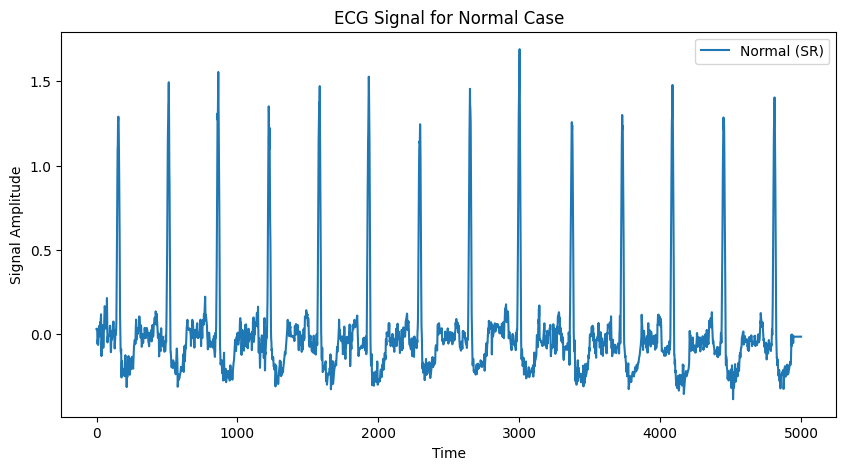

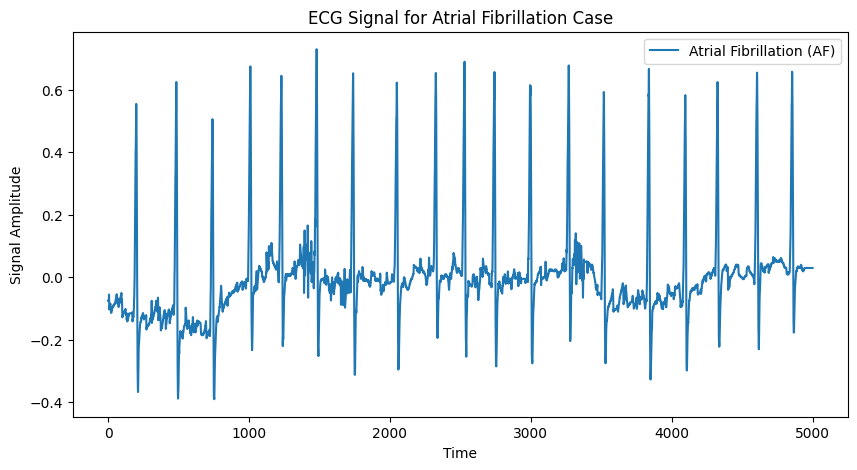

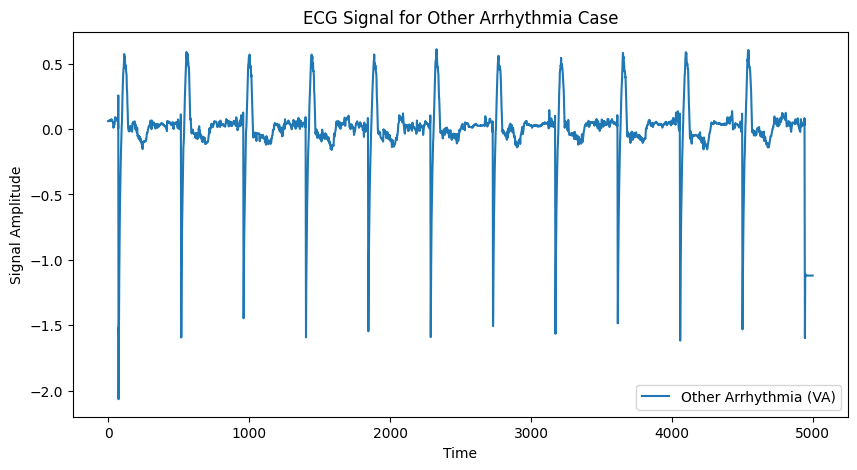

In [ ]:

for i in range(1):
    fig,ax = plt.subplots(1,1,figsize=(10,5),sharex=True,sharey=False)
    ax.plot(ecgeq_arr[normal_case, :, i], label='Normal (SR)')
    ax.set_title('ECG Signal for Normal Case')
    ax.set_xlabel('Time')
    ax.set_ylabel('Signal Amplitude')
    ax.legend()

    # Plot for Atrial Fibrillation Case
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=False)
    ax.plot(ecgeq_arr[afib_case, :, i], label='Atrial Fibrillation (AF)')
    ax.set_title('ECG Signal for Atrial Fibrillation Case')
    ax.set_xlabel('Time')
    ax.set_ylabel('Signal Amplitude')
    ax.legend()

    # Plot for Other Arrhythmia Case
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=False)
    ax.plot(ecgeq_arr[other_case, :, i], label='Other Arrhythmia (VA)')
    ax.set_title('ECG Signal for Other Arrhythmia Case')
    ax.set_xlabel('Time')
    ax.set_ylabel('Signal Amplitude')
    ax.legend()


## Loading a combined ECG waveform + patient data dataset

In [ ]:
# CSV link: https://github.com/tvo10/atrial-fibrillation-detection/tree/main
df = pd.read_csv('data/af_dataset.csv')
df

,I,II,III,aVF,aVR,aVL,V1,V2,V3,V4,...,weight,nurse,site,device,heart_axis,validated_by,second_opinion,validated_by_human,pacemaker,strat_fold
0,-0.005,0.135,0.140,-0.065,-0.073,0.137,-0.125,-0.090,-0.110,-0.210,...,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
1,-0.005,0.135,0.140,-0.065,-0.073,0.137,-0.125,-0.090,-0.110,-0.211,...,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
2,-0.005,0.131,0.136,-0.063,-0.070,0.133,-0.125,-0.082,-0.102,-0.190,...,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
3,-0.005,0.130,0.135,-0.063,-0.070,0.132,-0.122,-0.077,-0.094,-0.172,...,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
4,-0.005,0.128,0.133,-0.062,-0.069,0.130,-0.119,-0.071,-0.084,-0.157,...,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319171,0.010,0.170,0.160,-0.090,-0.075,0.165,0.155,0.365,0.230,0.030,...,69.841845,1.0,2.0,1,3.0,1.0,0,1,0.0,8
4319172,0.014,0.174,0.160,-0.094,-0.073,0.167,0.155,0.368,0.245,0.029,...,69.841845,1.0,2.0,1,3.0,1.0,0,1,0.0,8
4319173,0.016,0.176,0.160,-0.096,-0.073,0.167,0.155,0.383,0.261,0.040,...,69.841845,1.0,2.0,1,3.0,1.0,0,1,0.0,8
4319174,0.014,0.174,0.160,-0.094,-0.073,0.167,0.155,0.406,0.282,0.059,...,69.841845,1.0,2.0,1,3.0,1.0,0,1,0.0,8


In [ ]:
for i in range(26):
    df[df.columns[i]] = df[df.columns[i]].astype('float64')

# get info for columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4319176 entries, 0 to 4319175
Data columns (total 26 columns):
 #   Column              Dtype  
---  ------              -----  
 0   I                   float64
 1   II                  float64
 2   III                 float64
 3   aVF                 float64
 4   aVR                 float64
 5   aVL                 float64
 6   V1                  float64
 7   V2                  float64
 8   V3                  float64
 9   V4                  float64
 10  V5                  float64
 11  V6                  float64
 12  ritmi               float64
 13  age                 float64
 14  sex                 float64
 15  height              float64
 16  weight              float64
 17  nurse               float64
 18  site                float64
 19  device              float64
 20  heart_axis          float64
 21  validated_by        float64
 22  second_opinion      float64
 23  validated_by_human  float64
 24  pacemaker           floa

### Train-test-split

In [ ]:
X = df.drop(columns='ritmi')
y = df['ritmi']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size = 0.25, random_state = 1234)
X = df.drop(columns = ['ritmi','heart_axis','pacemaker','second_opinion','strat_fold','validated_by','validated_by_human'])
# X = df.iloc[:, :11]
# y = df['ritmi']
# X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4319176 entries, 0 to 4319175
Data columns (total 19 columns):
 #   Column  Dtype  
---  ------  -----  
 0   I       float64
 1   II      float64
 2   III     float64
 3   aVF     float64
 4   aVR     float64
 5   aVL     float64
 6   V1      float64
 7   V2      float64
 8   V3      float64
 9   V4      float64
 10  V5      float64
 11  V6      float64
 12  age     float64
 13  sex     float64
 14  height  float64
 15  weight  float64
 16  nurse   float64
 17  site    float64
 18  device  float64
dtypes: float64(19)
memory usage: 626.1 MB


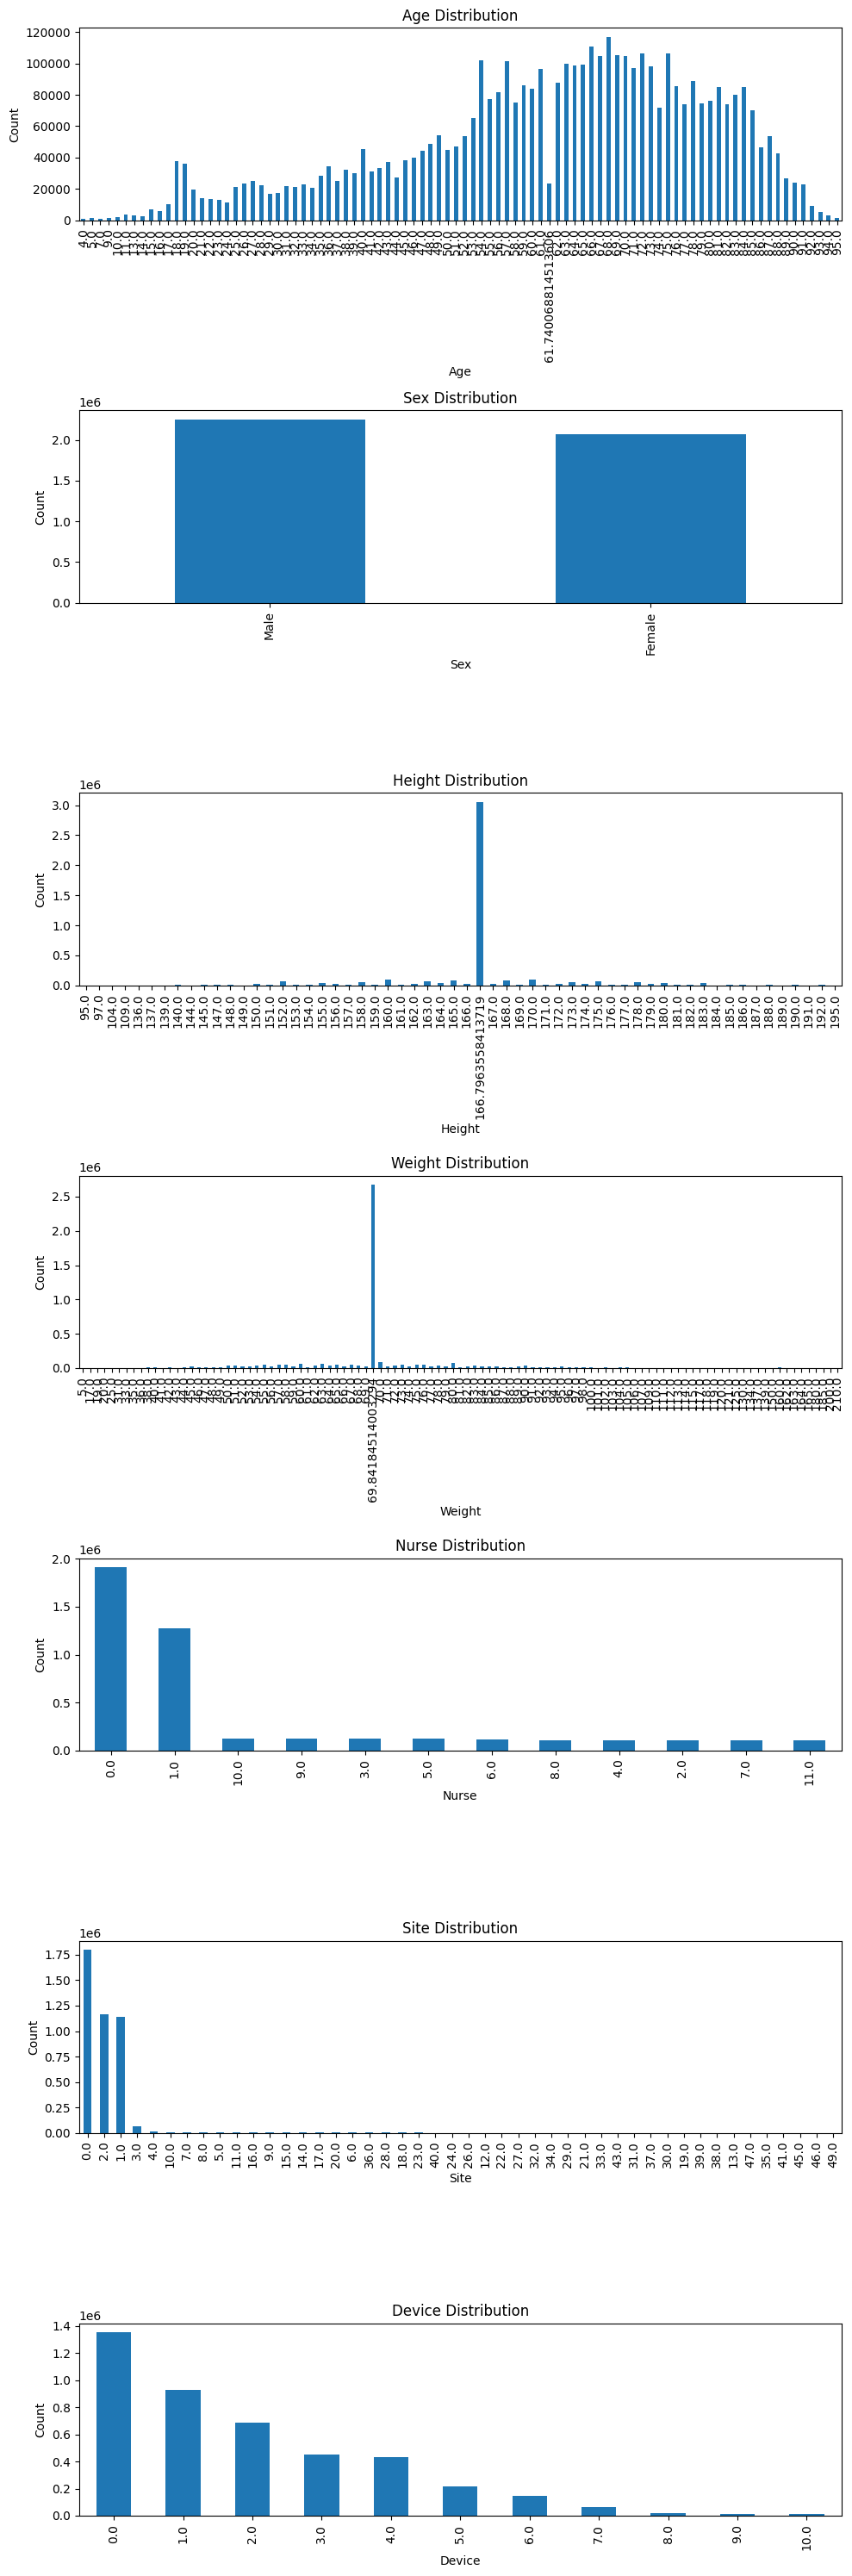

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(7, 1, figsize=(10, 30))

# Plot for 'Age'
df['age'].value_counts().sort_index().plot(kind='bar', ax=axes[0], title='Age Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

# Plot for 'Sex'
df['sex'].value_counts().plot(kind='bar', ax=axes[1], title='Sex Distribution')
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Male', 'Female'])  # Adjust labels accordingly

# Plot for 'Height'
df['height'].value_counts().sort_index().plot(kind='bar', ax=axes[2], title='Height Distribution')
axes[2].set_xlabel('Height')
axes[2].set_ylabel('Count')

# Plot for 'Weight'
df['weight'].value_counts().sort_index().plot(kind='bar', ax=axes[3], title='Weight Distribution')
axes[3].set_xlabel('Weight')
axes[3].set_ylabel('Count')

# Plot for 'Nurse'
df['nurse'].value_counts().plot(kind='bar', ax=axes[4], title='Nurse Distribution')
axes[4].set_xlabel('Nurse')
axes[4].set_ylabel('Count')

# Plot for 'Site'
df['site'].value_counts().plot(kind='bar', ax=axes[5], title='Site Distribution')
axes[5].set_xlabel('Site')
axes[5].set_ylabel('Count')

# Plot for 'Device'
df['device'].value_counts().plot(kind='bar', ax=axes[6], title='Device Distribution')
axes[6].set_xlabel('Device')
axes[6].set_ylabel('Count')

plt.tight_layout()
plt.show()

# MLP Definition and Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
# Determine the number of features and unique classes
num_features = X_train_tensor.shape[1]
num_classes = len(y.unique())

# Initialize the model, loss function, and optimizer
model = SimpleMLP(num_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# DataLoader for batch processing
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

## Training

In [ ]:
import torch

# Training the model
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate loss
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_predictions / total_predictions

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')


Epoch 1/20, Loss: 0.8642, Accuracy: 0.5499
Epoch 2/20, Loss: 0.7481, Accuracy: 0.6205
Epoch 3/20, Loss: 0.6949, Accuracy: 0.6531
Epoch 4/20, Loss: 0.6607, Accuracy: 0.6735
Epoch 5/20, Loss: 0.6364, Accuracy: 0.6877
Epoch 6/20, Loss: 0.6197, Accuracy: 0.6963
Epoch 7/20, Loss: 0.6063, Accuracy: 0.7031
Epoch 8/20, Loss: 0.5942, Accuracy: 0.7092
Epoch 9/20, Loss: 0.5849, Accuracy: 0.7139
Epoch 10/20, Loss: 0.5770, Accuracy: 0.7182
Epoch 11/20, Loss: 0.5699, Accuracy: 0.7220
Epoch 12/20, Loss: 0.5633, Accuracy: 0.7252
Epoch 13/20, Loss: 0.5567, Accuracy: 0.7287
Epoch 14/20, Loss: 0.5522, Accuracy: 0.7315
Epoch 15/20, Loss: 0.5475, Accuracy: 0.7338
Epoch 16/20, Loss: 0.5437, Accuracy: 0.7358
Epoch 17/20, Loss: 0.5396, Accuracy: 0.7376
Epoch 18/20, Loss: 0.5360, Accuracy: 0.7397
Epoch 19/20, Loss: 0.5321, Accuracy: 0.7416
Epoch 20/20, Loss: 0.5287, Accuracy: 0.7432


In [ ]:
# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

# Calculate precision, recall, and other metrics
report = classification_report(y_test_tensor.numpy(), predicted.numpy(), target_names=["SR", "AF", "VA"])  # Adjust class names as needed
print(report)

              precision    recall  f1-score   support

          SR       0.81      0.65      0.72    335792
          AF       0.71      0.77      0.74    267846
          VA       0.74      0.80      0.77    476156

    accuracy                           0.75   1079794
   macro avg       0.75      0.74      0.74   1079794
weighted avg       0.75      0.75      0.75   1079794



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Convert to numpy arrays for sklearn compatibility
true_labels = y_test_tensor.numpy()
predicted_labels = predicted.numpy()

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# F1 Score
f1 = f1_score(true_labels, predicted_labels, average='macro')  # You can change 'macro' to 'micro', 'weighted', or 'none'
print("F1 Score:", f1)

Confusion Matrix:
 [[219879  32227  83686]
 [ 12350 205774  49722]
 [ 39064  53870 383222]]
F1 Score: 0.7438894493686522


In [ ]:
filepath = 'simple_mlp_model.pth'
torch.save(model, filepath)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import datasets

In [ ]:
# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Create a logistic regression model
model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.47919325352798775


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

f1 = f1_score(y_test, y_pred, average=None)
print(f'F1 Score: {f1}')

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

F1 Score: [0.22466129 0.46197226 0.58629098]
Confusion Matrix:
[[ 49821  68213 217758]
 [ 20129 131727 115990]
 [ 37779 102495 335882]]


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score


# Calculate precision and recall
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: [0.462466   0.43555475 0.50159342]
Recall: [0.14836863 0.49180126 0.70540327]


In [ ]:
!pip install joblib

In [ ]:
import joblib

# Assume 'model' is your trained logistic regression model
joblib.dump(model, 'logistic_regression_model.pkl')

['/content/drive/Shareddrives/OG_Mood_Lyric_Processors_CS272/CS284A/logistic_regression_model.pkl']